In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import seaborn as sns
sns.set(rc={'figure.figsize':(10, 5)})
sns.set_style("whitegrid", {'axes.grid' : False})
import datetime
import warnings
warnings.filterwarnings('ignore')
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
cRange = ['#475468', '#e7e6e6', '#4b73be', '#df8244', '#a5a5a5', '#f7c143',
          '#20406a', '#deeef8', '#2d6fc0', '#409cd4', '#5ccdd7', '#5ecb9e',
          '#a53218', '#c59933', '#f08a40', '#aa4f30', '#f7bf5d', '#d85733',
          '#728083', '#8babb4', '#7196ad', '#607397', '#8585c2', '#a687c1']
colors = ['#475468', '#e7e6e6', '#4b73be', 
          '#df8244', '#a5a5a5', '#f7c143'] 
cmapOffice = mpl.colors.ListedColormap([cRange[i] for i in range(0, 5)])
cmapBlue = mpl.colors.ListedColormap([cRange[i] for i in range(6, 11)])
cmapRed = mpl.colors.ListedColormap([cRange[i] for i in range(12, 17)])
cmapViolett = mpl.colors.ListedColormap([cRange[i] for i in range(18, 23)])

Correlation of Price Difference & Total Forecast Error [PEARSON]: -0.06597185641672222
Ttest_relResult(statistic=-33.150187008780485, pvalue=8.717250132395765e-234)


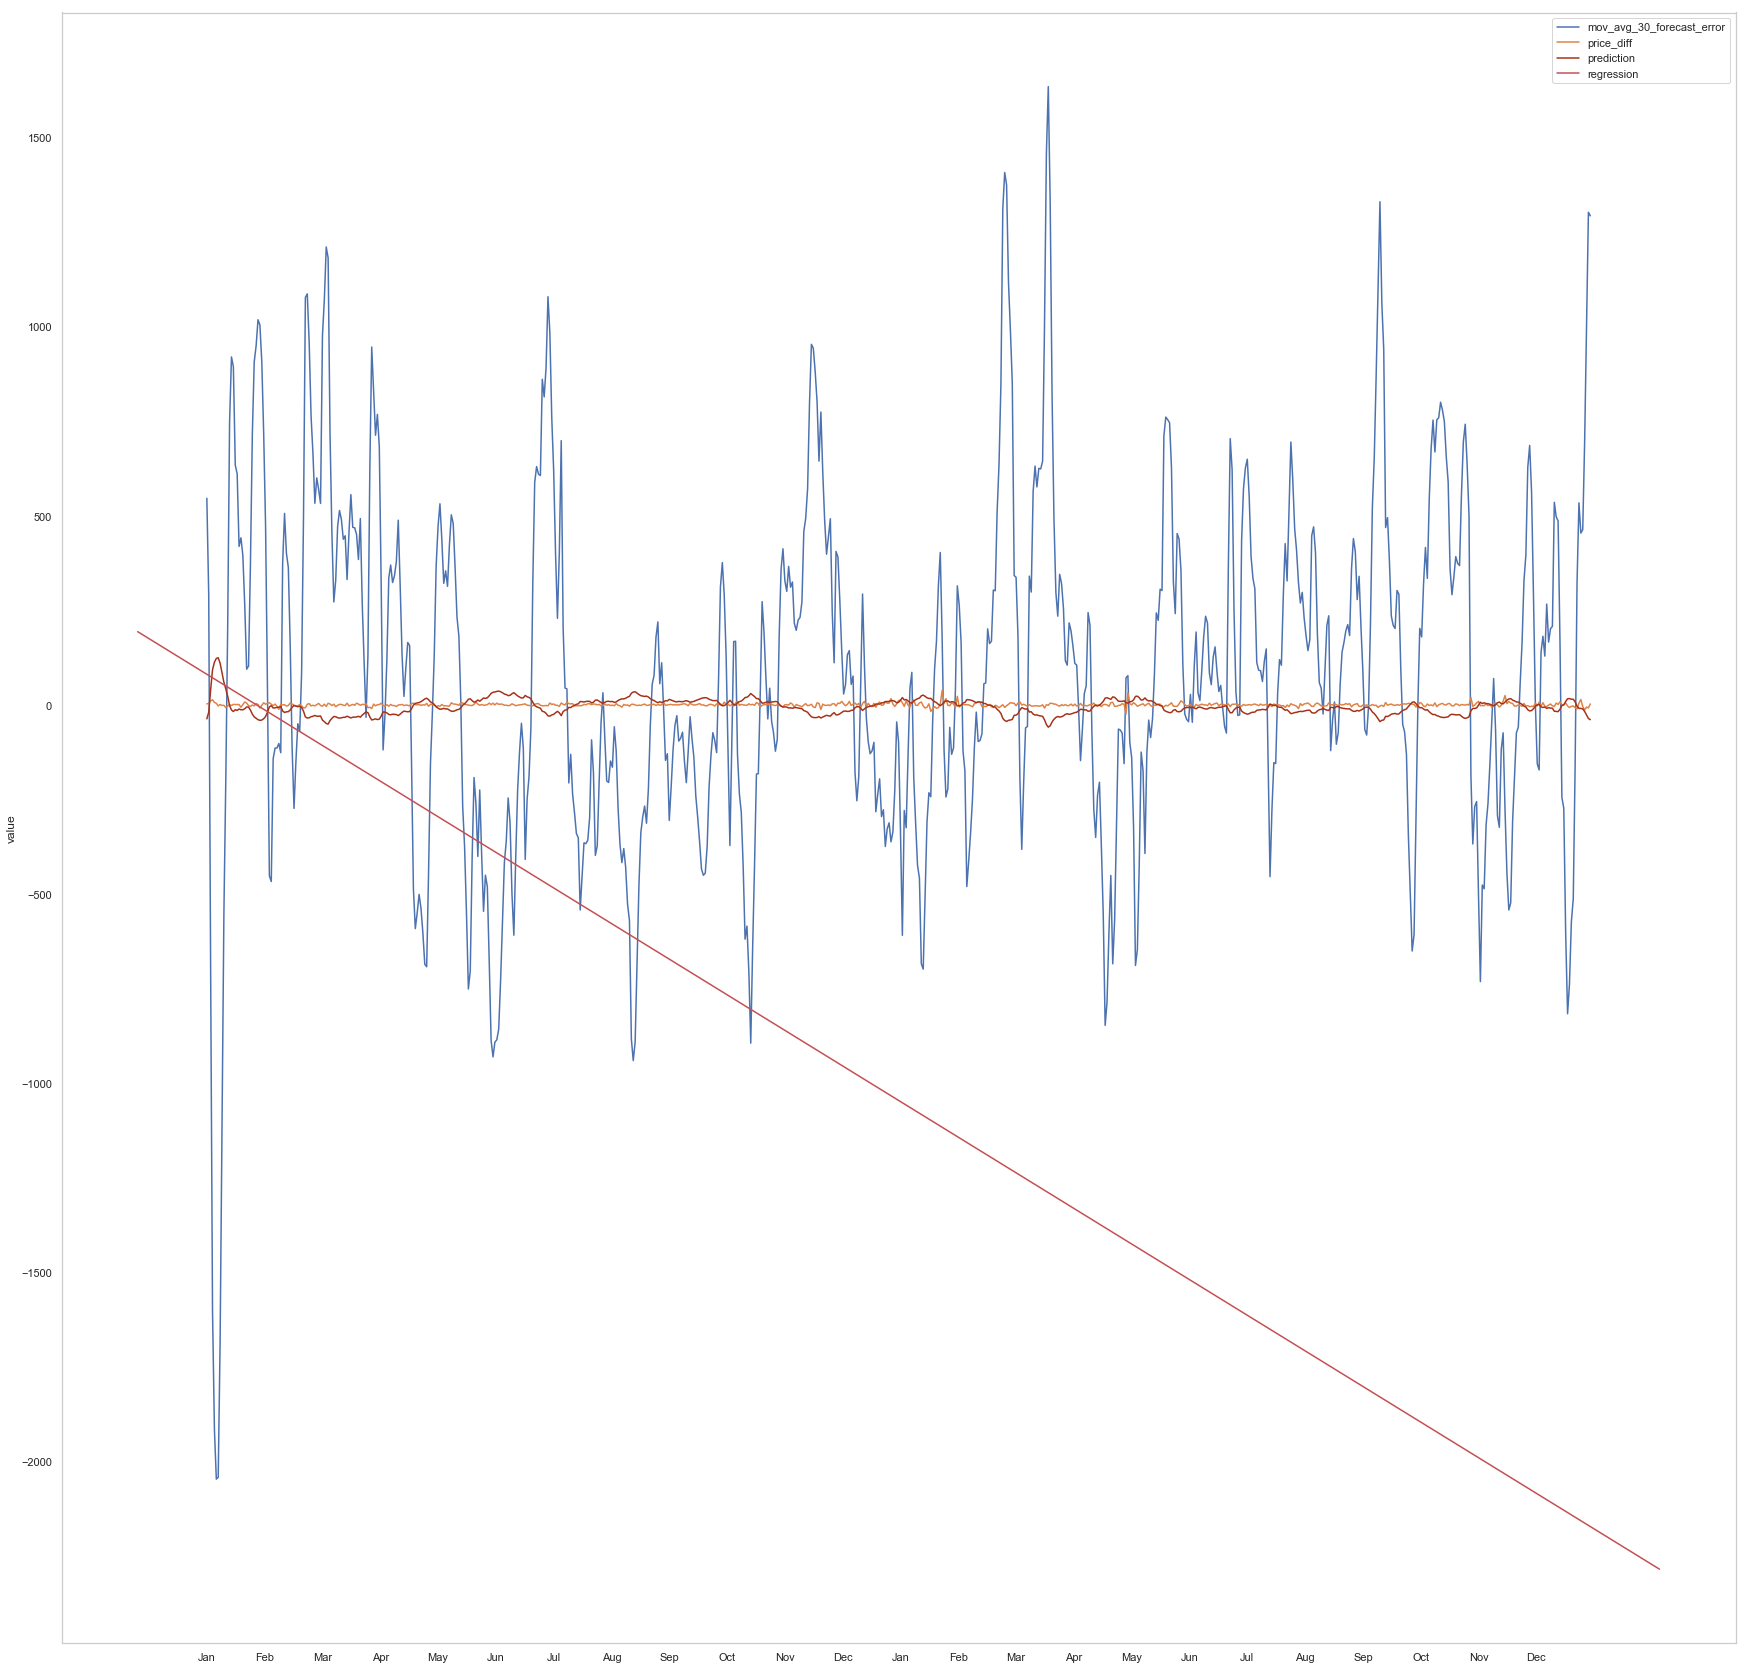

In [49]:
fullData = pd.read_csv("../00_data/data_with_calc_fields.csv", sep=";", decimal=",", index_col="datetime")
fullData.index = pd.to_datetime(fullData.index)

forecastErrorLabel = "mov_avg_30_forecast_error"

series_forecastError_wind = fullData["mov_avg_10_wind_forecast_error"]
series_forecastError_solar = fullData["mov_avg_10_solar_forecast_error"]
series_forecastError_total = fullData[forecastErrorLabel]
series_priceDifference = fullData["price_diff"]

corrCoeff_price_wind = series_priceDifference.corr(series_forecastError_wind, method="spearman")
corrCoeff_price_solar = series_priceDifference.corr(series_forecastError_solar, method="spearman")
corrCoeff_price_total_P = series_priceDifference.corr(series_forecastError_total, method="pearson")
corrCoeff_price_total_K = series_priceDifference.corr(series_forecastError_total, method="kendall")
corrCoeff_price_total_S = series_priceDifference.corr(series_forecastError_total, method="spearman")

# print("Correlation of Price Difference & Wind Forecast Error: " + str(corrCoeff_price_wind))
# print("Correlation of Price Difference & Solar Forecast Error: " + str(corrCoeff_price_solar))
print("Correlation of Price Difference & Total Forecast Error [PEARSON]: " + str(corrCoeff_price_total_P))
# print("Correlation of Price Difference & Total Forecast Error [KENDALL]: " + str(corrCoeff_price_total_K))
# print("Correlation of Price Difference & Total Forecast Error [SPEARMAN]: " + str(corrCoeff_price_total_S))

from scipy.stats import linregress
import scipy.stats as scipy
slope, intercept, rvalue, pvalue, stderr = linregress(series_priceDifference, series_forecastError_total)
print(scipy.ttest_rel(series_priceDifference, series_forecastError_total))

#####
fullData["pearson_predict"] = fullData[forecastErrorLabel].map(lambda x: x * corrCoeff_price_total_P)
fullData["kendall_predict"] = fullData[forecastErrorLabel].map(lambda x: x * corrCoeff_price_total_K)
fullData["spearman_predict"] = fullData[forecastErrorLabel].map(lambda x: x * corrCoeff_price_total_S)
#####

fig, ax = plt.subplots(figsize=(30, 30))

sns.lineplot(x="date", y="mov_avg_10_forecast_error", data=fullData, ax=ax, label=forecastErrorLabel, ci=None)
sns.lineplot(x="date", y="price_diff", data=fullData, ax=ax, label="price_diff", ci=None)
sns.lineplot(x="date", y="pearson_predict", data=fullData, ax=ax, label="prediction", ci=None)

x_vals = np.array(ax.get_xlim())
y_vals = intercept + slope * x_vals
sns.lineplot(x=x_vals, y=y_vals, ax=ax, label="regression", ci=None)

ax.legend()
ax.set_xlabel("")
ax.set_ylabel("value")
ax.set_xticks(np.arange(720, step=30.5))
ax.set_xticklabels(2*[month for month in months])
for child in ax.findobj(Line2D):
    if child.get_label() == "mov_avg_10_forecast_error":
        child.set_color(cRange[2])
    elif child.get_label() == "price_diff":
        child.set_color(cRange[3])
    elif child.get_label() == "prediction":
        child.set_color(cRange[12])

# Conclusion

Since the correlation coefficient is negative, a positive addition to the forecast error leads to a negative addition to the price difference.
         
- Positive addition to the FE (increase in production or reduction of forecasted amount) leads to negative addition to the PD:
    - PD was >= 0: (price increases toward intraday)
        - price increases less // PD might shift from being >= 0 to being < 0 --> then: price decreases & PD < 0
    - PD was < 0:(price decreases toward intraday)
        - price decrease more (PD stays in the range of < 0)
- Negative addition to the FE (reduction in production or increase of forecasted amount) leads to positive addition to the PD:
    - PD was >= 0: (price increases toward intraday)
        - price increases more (PD stays in the range >= 0)
    - PD was < 0:(price decreases toward intraday)
        - price decreases less // PD might shift from being < 0 to being >= 0 --> then: price increases & PD >= 0         